In [27]:
import pandas as pd

# Charger les données
file_path = 'Flux Crediteur_2021_2024_v1.xlsx'
data = pd.read_excel(file_path)

# Convertir la colonne 'Date' en format datetime
data['Date'] = pd.to_datetime(data['Date'])

# Extraire l'année des dates
data['Année'] = data['Date'].dt.year

# Calculer les caractéristiques des clients
client_stats = data.groupby('Clients').agg(
    Total_Montant=('mcfa', 'sum'),
    Mean_Montant=('mcfa', 'mean'),
    Annees_Actives=('Année', 'nunique')
).reset_index()

# Afficher les premières lignes des caractéristiques des clients
print(client_stats.head())


   Clients  Total_Montant  Mean_Montant  Annees_Actives
0      830   4.864236e+09  1.186399e+08               4
1     1400   2.223773e+07  5.423836e+05               4
2     2900   4.830964e+09  1.178284e+08               4
3     3100   7.244486e+10  1.766948e+09               4
4     4640   1.065672e+09  2.599201e+07               4


In [28]:
from sklearn.preprocessing import StandardScaler

# Standardiser les données
scaler = StandardScaler()
client_stats_scaled = scaler.fit_transform(client_stats[['Total_Montant', 'Mean_Montant', 'Annees_Actives']])


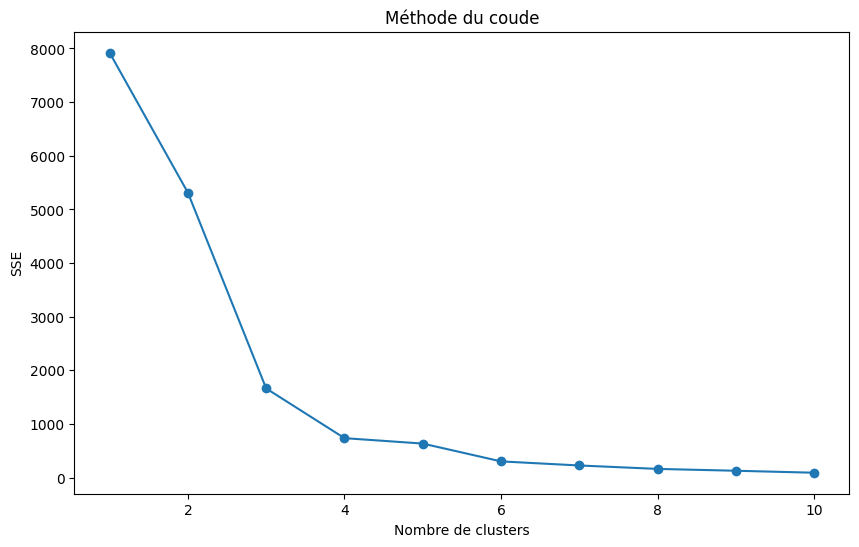

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Méthode du coude pour déterminer le nombre optimal de clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(client_stats_scaled)
    sse.append(kmeans.inertia_)

# Tracer la méthode du coude
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('SSE')
plt.show()


In [30]:
# Choisir le nombre optimal de clusters 
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
client_stats['Cluster'] = kmeans.fit_predict(client_stats_scaled)


In [31]:
# Calculer les statistiques descriptives pour chaque cluster
cluster_stats = client_stats.groupby('Cluster').agg(
    Total_Montant_Mean=('Total_Montant', 'mean'),
    Total_Montant_Sum=('Total_Montant', 'sum'),
    Mean_Montant_Mean=('Mean_Montant', 'mean'),
    Annees_Actives_Mean=('Annees_Actives', 'mean')
).reset_index()

print("\nStatistiques descriptives par Cluster:")
print(cluster_stats)



Statistiques descriptives par Cluster:
   Cluster  Total_Montant_Mean  Total_Montant_Sum  Mean_Montant_Mean  \
0        0        3.794259e+09       7.440542e+12       9.254299e+07   
1        1        4.602170e+08       3.042035e+11       2.846617e+07   
2        2        2.202558e+11       3.303838e+12       5.372094e+09   
3        3        6.110771e+11       1.833231e+12       1.490432e+10   

   Annees_Actives_Mean  
0             3.998470  
1             1.906203  
2             4.000000  
3             4.000000  


In [32]:
# Mapping des clusters avec les noms marketing basés sur les statistiques descriptives
cluster_mapping = {
    cluster_stats.loc[cluster_stats['Total_Montant_Mean'].idxmin(), 'Cluster']: 'Client Prospect',          # Montant total moyen bas, actif depuis peu
    cluster_stats.loc[(cluster_stats['Total_Montant_Mean'] > cluster_stats['Total_Montant_Mean'].min()) & (cluster_stats['Annees_Actives_Mean'] < 4), 'Cluster']: 'Client Régulier',          # Montant total moyen modéré, actif régulièrement
    cluster_stats.loc[cluster_stats['Total_Montant_Mean'].idxmax(), 'Cluster']: 'Client VIP',               # Montant total et moyen par transaction très élevés, actif depuis longtemps
    cluster_stats.loc[(cluster_stats['Total_Montant_Mean'] > cluster_stats['Total_Montant_Mean'].min()) & (cluster_stats['Annees_Actives_Mean'] == 4), 'Cluster']: 'Client à Forte Valeur'     # Montant total moyen élevé, mais moins actif que les VIP
}

# Appliquer le mapping des clusters
client_stats['Segment'] = client_stats['Cluster'].map(cluster_mapping)

# Afficher les résultats en précisant le nombre de clients par segment
segments_counts = client_stats['Segment'].value_counts().reset_index()
segments_counts.columns = ['Segment', 'Nombre de Clients']

# Calculer les statistiques descriptives pour chaque segment
segment_stats = client_stats.groupby('Segment').agg(
    Total_Montant_Mean=('Total_Montant', 'mean'),
    Total_Montant_Sum=('Total_Montant', 'sum'),
    Mean_Montant_Mean=('Mean_Montant', 'mean'),
    Annees_Actives_Mean=('Annees_Actives', 'mean')
).reset_index()

# Afficher les résultats
print("\nNombre de Clients par Segment:")
print(segments_counts)

print("\nStatistiques descriptives par Segment:")
print(segment_stats)


TypeError: unhashable type: 'Series'

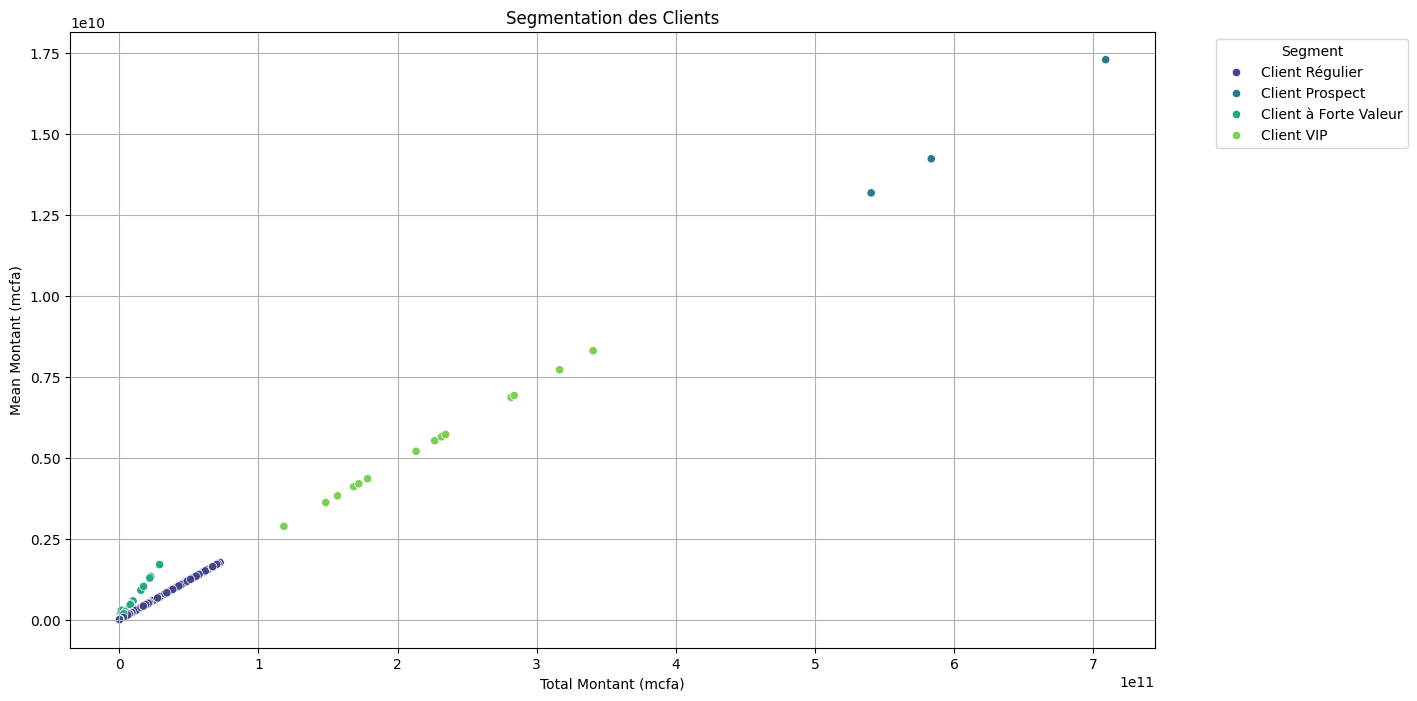

In [ ]:
import seaborn as sns

# Visualiser les segments
plt.figure(figsize=(14, 8))
sns.scatterplot(x='Total_Montant', y='Mean_Montant', hue='Segment', data=client_stats, palette='viridis')
plt.title('Segmentation des Clients')
plt.xlabel('Total Montant (mcfa)')
plt.ylabel('Mean Montant (mcfa)')
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


In [ ]:
# Visualiser les segments
plt.figure(figsize=(14, 8))
sns.scatterplot(x='Total_Montant', y='Mean_Montant', hue='Segment', data=client_stats, palette='viridis')
plt.title('Segmentation des Clients')
plt.xlabel('Total Montant (mcfa)')
plt.ylabel('Mean Montant (mcfa)')
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()